In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import os
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()
files = sorted(glob.glob("data/classified/climate_tweets_*.csv"))
print(files)
pd.set_option('display.max_colwidth', -1)

<IPython.core.display.Javascript object>

['data/classified/climate_tweets_2006.csv', 'data/classified/climate_tweets_2007.csv', 'data/classified/climate_tweets_2008.csv', 'data/classified/climate_tweets_2009.csv', 'data/classified/climate_tweets_2010.csv', 'data/classified/climate_tweets_2011.csv', 'data/classified/climate_tweets_2012.csv', 'data/classified/climate_tweets_2013.csv', 'data/classified/climate_tweets_2014.csv', 'data/classified/climate_tweets_2015.csv', 'data/classified/climate_tweets_2016.csv', 'data/classified/climate_tweets_2017.csv', 'data/classified/climate_tweets_2018.csv', 'data/classified/climate_tweets_2019.csv', 'data/classified/climate_tweets_2020.csv']


<ipython-input-23-486803b82fbb>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
%%time
df = pd.concat(pd.read_csv(f, sep=";", engine="c", lineterminator="\n") for f in tqdm(files))

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 14min 13s, sys: 3min 14s, total: 17min 27s
Wall time: 21min 46s


In [3]:
print(len(df))

32335076


In [4]:
df=df.drop_duplicates(subset="tweet_id")
print(len(df))

32261854


In [5]:
%%time
df.timestamp = pd.to_datetime(df.timestamp)
df.index = df.timestamp

CPU times: user 14.6 s, sys: 2.4 s, total: 17 s
Wall time: 16.8 s


In [6]:
daycounts = df.timestamp.resample("D").count()
daycounts[daycounts == 0].index

DatetimeIndex(['2006-06-07', '2006-06-08', '2006-06-09', '2006-06-10',
               '2006-06-11', '2006-06-12', '2006-06-13', '2006-06-14',
               '2006-06-15', '2006-06-16',
               ...
               '2010-03-15', '2010-03-16', '2010-03-17', '2010-03-18',
               '2010-03-19', '2010-03-20', '2010-03-21', '2019-08-29',
               '2020-02-17', '2020-02-18'],
              dtype='datetime64[ns]', name='timestamp', length=230, freq=None)

In [7]:
df.columns

Index(['username', 'fullname', 'user_id', 'tweet_id', 'tweet_url', 'timestamp',
       'timestamp_epochs', 'replies', 'retweets', 'likes', 'is_retweet',
       'retweeter_username', 'retweeter_userid', 'retweet_id', 'text', 'html',
       'text_with_emoji', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

In [8]:
df.timestamp.resample("M").count().median()

158799.5

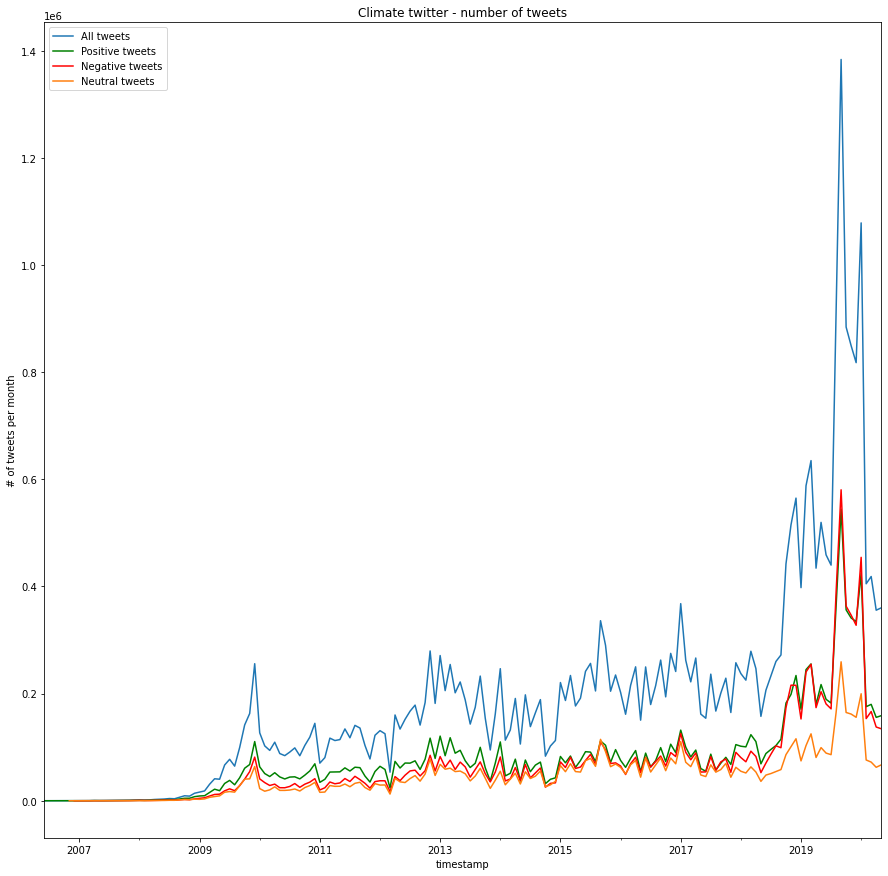

In [9]:
df.timestamp.resample("M").count().plot(figsize=(15,15), title="Climate twitter - number of tweets")
df.timestamp[df["compound"] > 0.05].resample("M").count().plot(color='g')
df.timestamp[df["compound"] < -0.05].resample("M").count().plot(color='r')
df.timestamp[df["compound"].between(-.05, .05)].resample("M").count().plot()
plt.legend(["All tweets", "Positive tweets", "Negative tweets", "Neutral tweets"])
plt.ylabel("# of tweets per month")
plt.show()

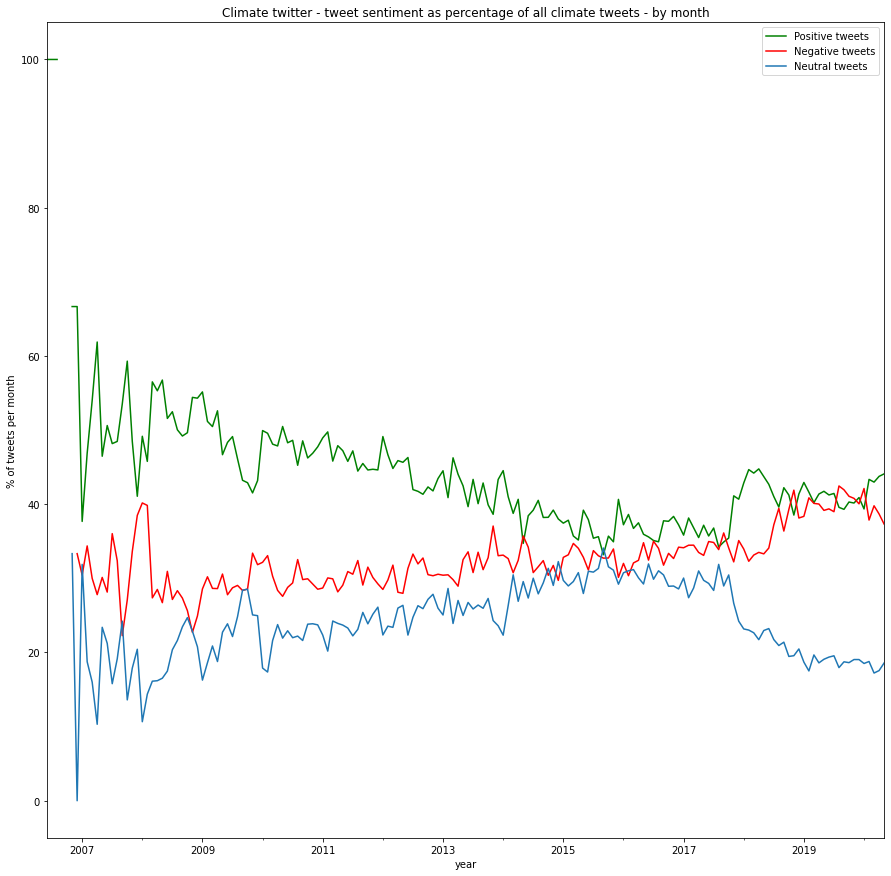

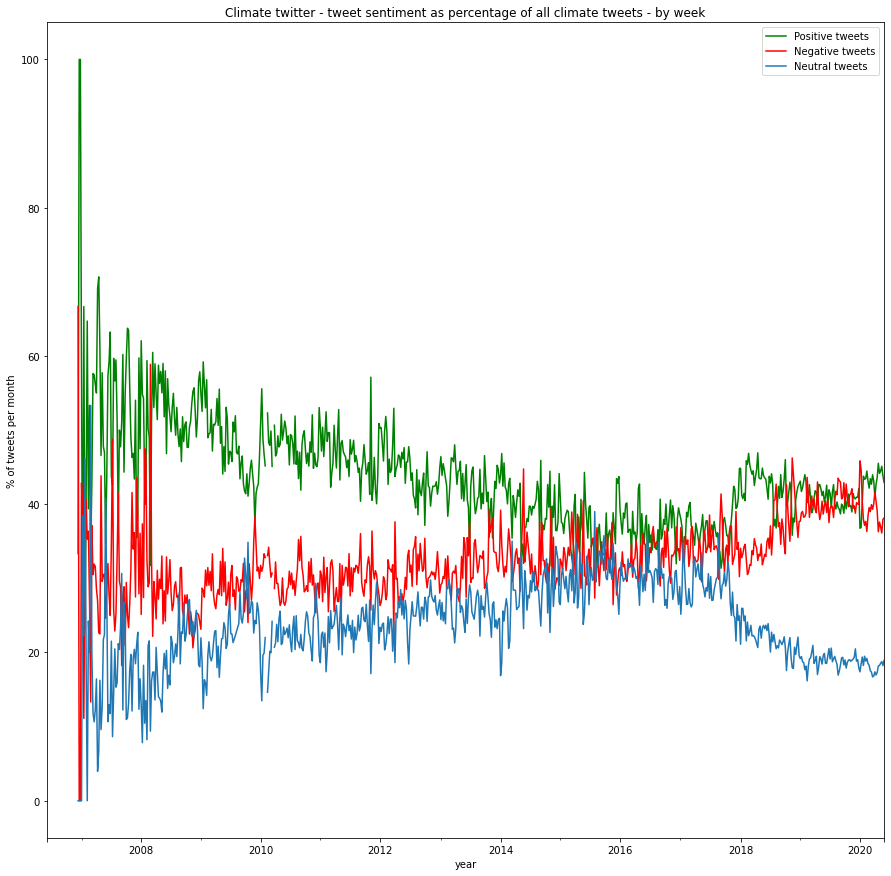

In [10]:
#et_by_month_pc = et_by_month.count() / by_month.count() * 100

all_tweets_monthly = df.timestamp.resample("M").count()
pos_tweets = df.timestamp[df["compound"] > 0.05].resample("M").count()
pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
neg_tweets = df.timestamp[df["compound"] < -0.05].resample("M").count()
neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
neutral_tweets = df.timestamp[df["compound"].between(-.05, .05)].resample("M").count()
neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

pos_tweets_pc.plot(figsize=(15,15), title="Climate twitter - tweet sentiment as percentage of all climate tweets - by month",color="g")
neg_tweets_pc.plot(color='r')
neutral_tweets_pc.plot()
plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
plt.xlabel("year")
plt.ylabel("% of tweets per month")
plt.show()


#et_by_month_pc = et_by_month.count() / by_month.count() * 100
all_tweets_monthly = df.timestamp.resample("W").count()
pos_tweets = df.timestamp[df["compound"] > 0.05].resample("W").count()
pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
neg_tweets = df.timestamp[df["compound"] < -0.05].resample("W").count()
neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
neutral_tweets = df.timestamp[df["compound"].between(-.05, .05)].resample("W").count()
neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

pos_tweets_pc.plot(figsize=(15,15), title="Climate twitter - tweet sentiment as percentage of all climate tweets - by week",color="g")
neg_tweets_pc.plot(color='r')
neutral_tweets_pc.plot()
plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
plt.xlabel("year")
plt.ylabel("% of tweets per month")
plt.show()

In [22]:
%%time
def display_filtered_df(df, pattern, n=1000, extracols = []):
    if len(df) < n:
        filtered_df = df
    else:
        filtered_df = df.sample(n)
    filtered_df["text_with_emoji_formatted"] = filtered_df.text_with_emoji.str.replace(pattern, lambda x: "<b>" + x.group() + "</b>", case=False)
    show(filtered_df[["text_with_emoji_formatted", "compound"] + extracols],
        order=[[2, 'desc']],
        orderClasses=False,
        createdRow="""function( row, data, dataIndex ) {
          if (data[2] > 0) {
            $(row).css('background-color', 'rgba(0,255,0,.2)');
          } else if (data[2] == 0) {
            $(row).css('background-color', 'rgba(0,0,255,.2)');
          } else {
            $(row).css('background-color', 'rgba(255,0,0,.2)');
          }
        }""", scrollY="800px", scrollCollapse=True, paging=False, columnDefs=[{"width": "120px", "targets": "_all"}])

pattern = r"global.?warming|climate.?chang|sea.?level.?ris|rising.?sea.?level|climate.?crisis|climate.?action|extreme.?weather|biodiversity|IPCC|Paris.?accord"
display_filtered_df(df, pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.


,text_with_emoji_formatted,compound
timestamp,,


CPU times: user 2.7 s, sys: 91.6 ms, total: 2.79 s
Wall time: 2.77 s


<AxesSubplot:title={'center':'Mean sentiment per month'}, xlabel='timestamp'>

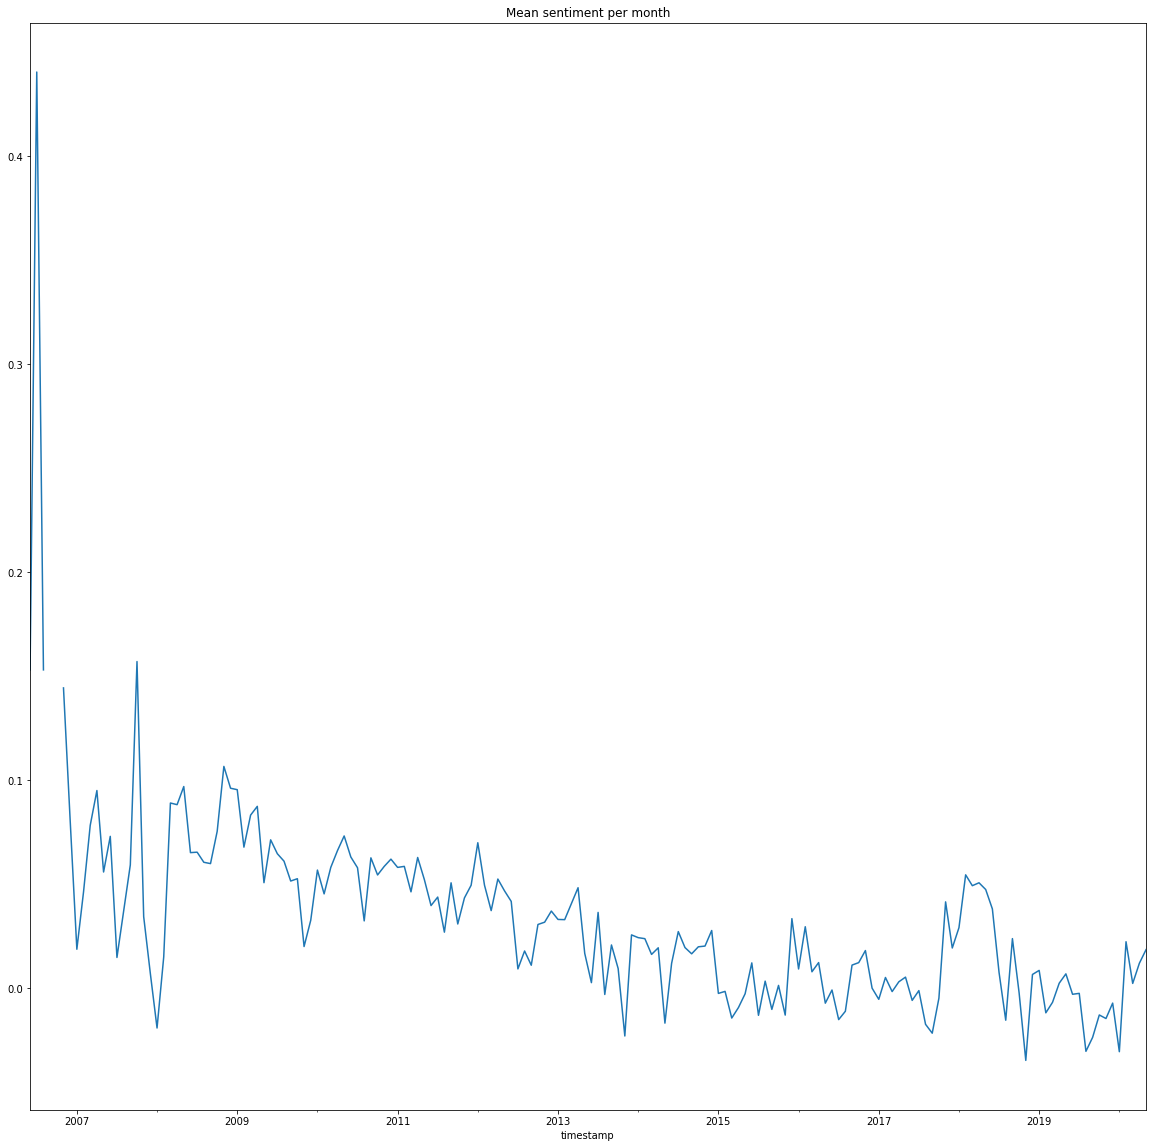

In [15]:
df["compound"].resample("M").mean().plot(figsize=(20,20), title="Mean sentiment per month")

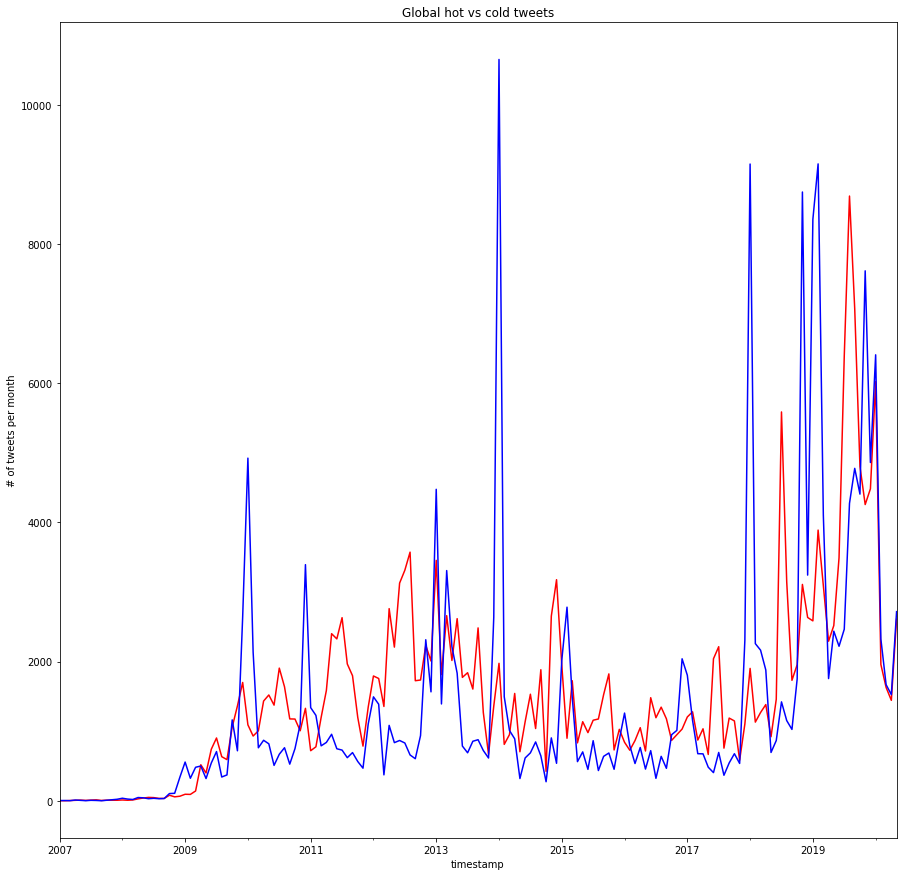

In [16]:
df.timestamp[df.text.str.contains(r"\bhot\b", na=False)].resample("M").count().plot(figsize=(15, 15), title="Global hot vs cold tweets", color="r")
df.timestamp[df.text.str.contains(r"\bcold\b", na=False)].resample("M").count().plot(color="b")
plt.ylabel("# of tweets per month")
plt.show()

In [17]:
print(df.columns)
display_filtered_df(df[df.likes > 2e5], pattern, 500, ["username", "likes"])

Index(['username', 'fullname', 'user_id', 'tweet_id', 'tweet_url', 'timestamp',
       'timestamp_epochs', 'replies', 'retweets', 'likes', 'is_retweet',
       'retweeter_username', 'retweeter_userid', 'retweet_id', 'text', 'html',
       'text_with_emoji', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')


<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text_with_emoji_formatted,compound,username,likes
timestamp,,,,


In [18]:
display_filtered_df(df[df.username == "realDonaldTrump"], pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text_with_emoji_formatted,compound
timestamp,,


In [24]:
%%time
pattern = r"fake|not real|isn'?t real|doesn'?t exist|hoax|propaganda|conspiracy"
deniers = df[df.text.str.contains(pattern, case=False, na=False)]
print(len(deniers))
display_filtered_df(deniers, pattern)

941086


<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.


,text_with_emoji_formatted,compound
timestamp,,


CPU times: user 10min 48s, sys: 292 ms, total: 10min 49s
Wall time: 10min 48s


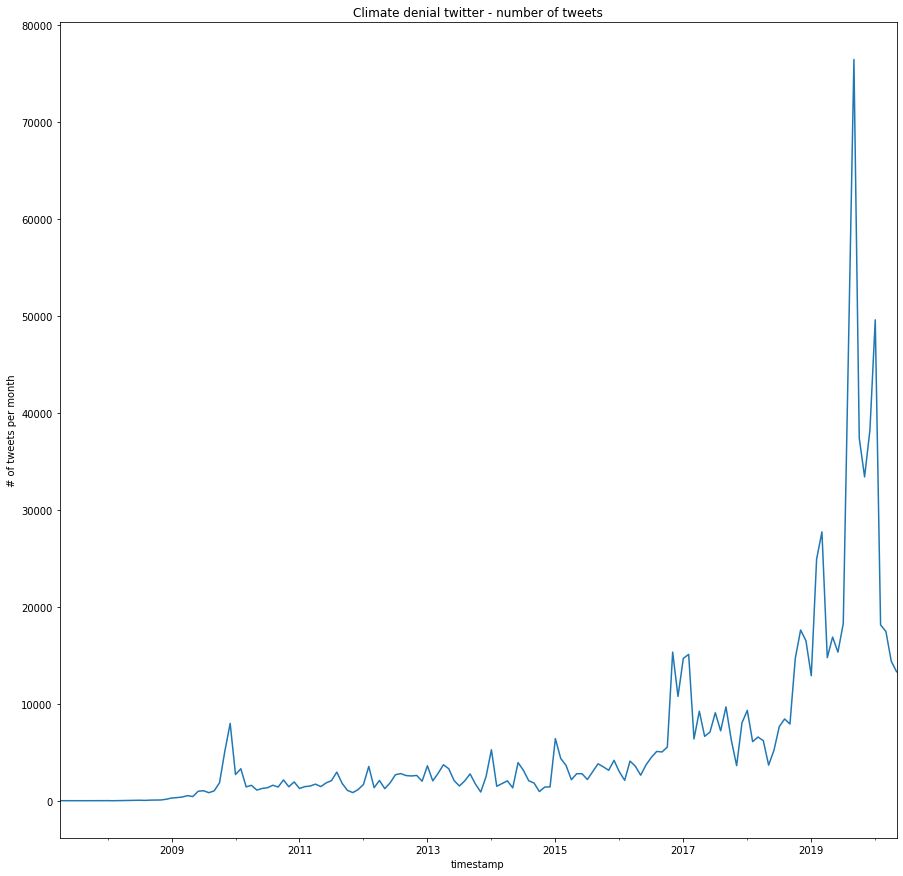

In [25]:
deniers.timestamp.resample("M").count().plot(figsize=(15,15), title="Climate denial twitter - number of tweets")
plt.ylabel("# of tweets per month")
plt.show()

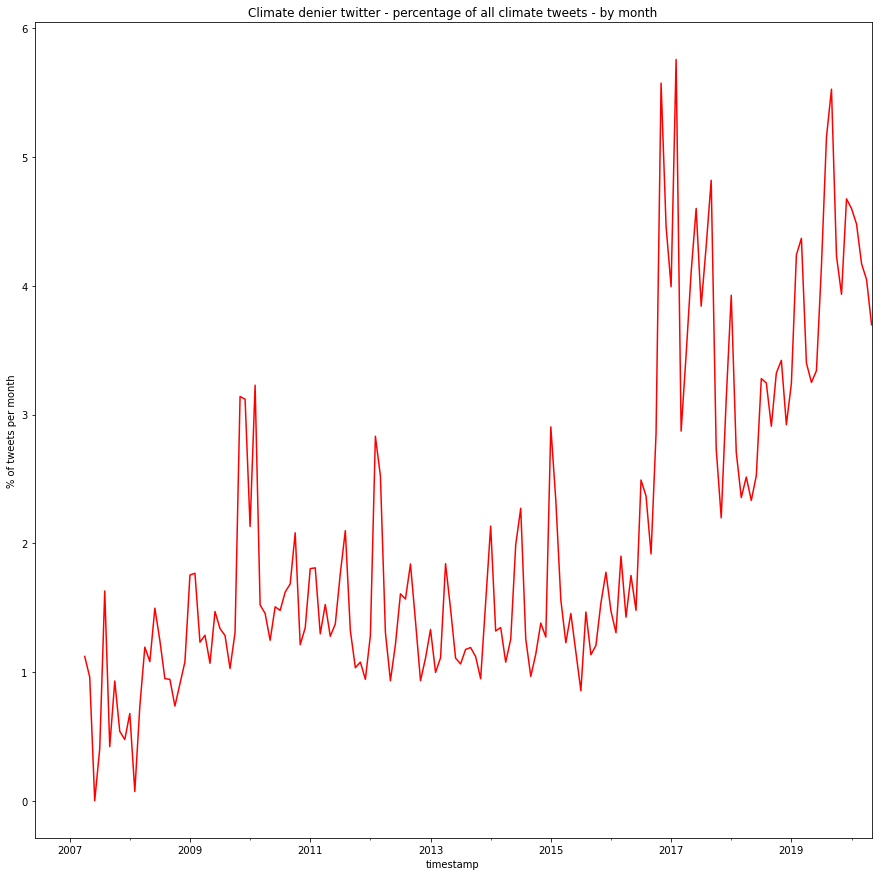

In [26]:
all_tweets_monthly = df.timestamp.resample("M").count()
denier_tweets = deniers.timestamp.resample("M").count()
denier_tweet_pc = denier_tweets / all_tweets_monthly * 100

denier_tweet_pc.plot(figsize=(15,15), title="Climate denier twitter - percentage of all climate tweets - by month",color="r")
plt.ylabel("% of tweets per month")
plt.show()

In [27]:
#%%time
# Save datasets of unique users and ids for bot scoring. Takes ~13min
#df[["username", "user_id"]].value_counts().to_csv("data/users.csv")

In [28]:
botscores = pd.read_csv("data/botscores.csv")
botscores

,user_id


In [29]:
%%time
merged = pd.merge(df, botscores, on="user_id")
merged

CPU times: user 4min 9s, sys: 7.77 s, total: 4min 16s
Wall time: 4min 15s


,username


In [30]:
merged.index = merged.timestamp
bot_tweets = merged[merged.prob_bot > .5]
human_tweets = merged[merged.prob_bot < .5]

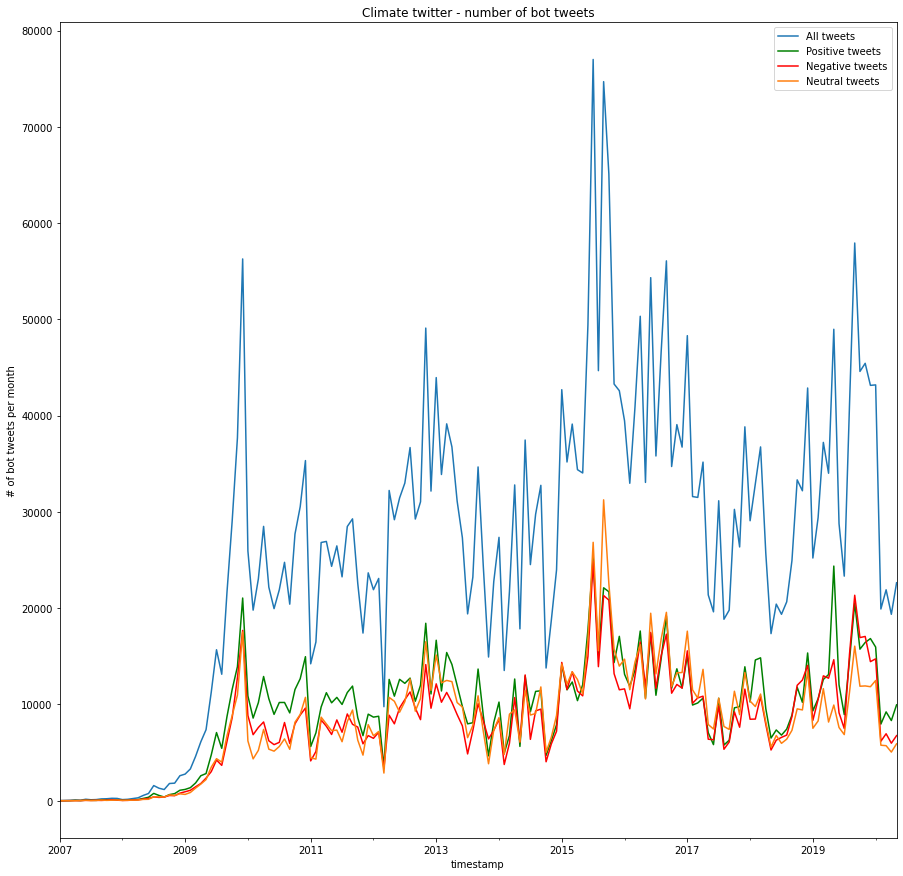

In [31]:
bot_tweets.timestamp.resample("M").count().plot(figsize=(15,15), title="Climate twitter - number of bot tweets")
bot_tweets.timestamp[bot_tweets["compound"] > 0.05].resample("M").count().plot(color='g')
bot_tweets.timestamp[bot_tweets["compound"] < -0.05].resample("M").count().plot(color='r')
bot_tweets.timestamp[bot_tweets["compound"].between(-.05, .05)].resample("M").count().plot()
plt.legend(["All tweets", "Positive tweets", "Negative tweets", "Neutral tweets"])
plt.ylabel("# of bot tweets per month")
plt.show()

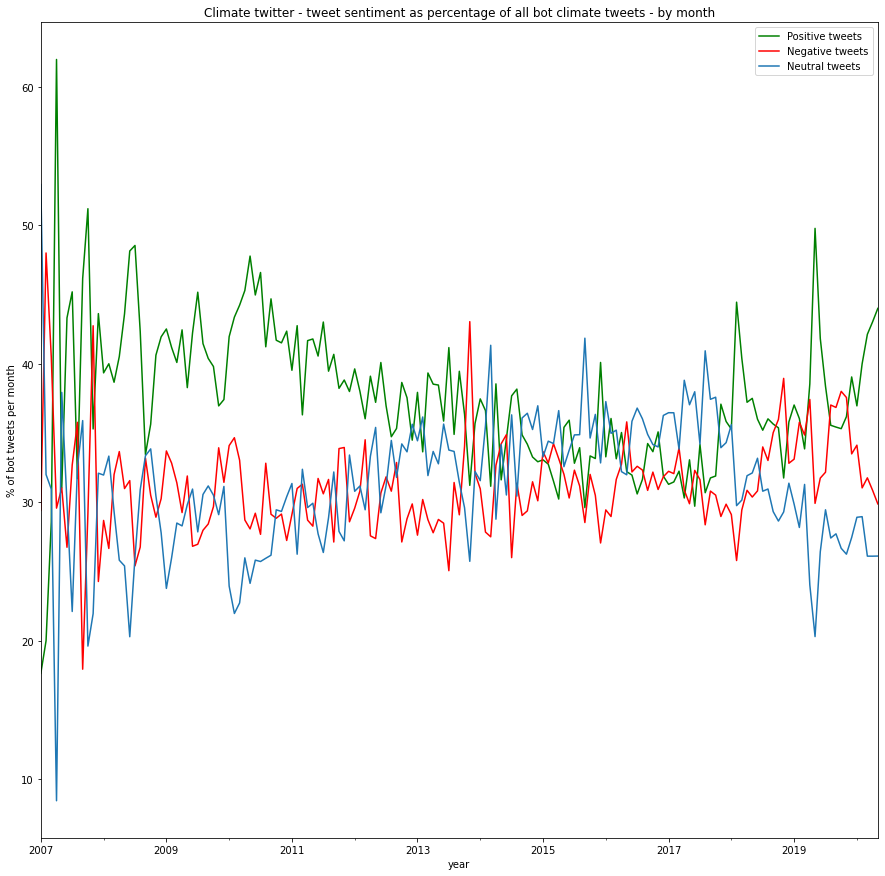

In [32]:
all_tweets_monthly = bot_tweets.timestamp.resample("M").count()
pos_tweets = bot_tweets.timestamp[bot_tweets["compound"] > 0.05].resample("M").count()
pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
neg_tweets = bot_tweets.timestamp[bot_tweets["compound"] < -0.05].resample("M").count()
neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
neutral_tweets = bot_tweets.timestamp[bot_tweets["compound"].between(-.05, .05)].resample("M").count()
neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

pos_tweets_pc.plot(figsize=(15,15), title="Climate twitter - tweet sentiment as percentage of all bot climate tweets - by month",color="g")
neg_tweets_pc.plot(color='r')
neutral_tweets_pc.plot()
plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
plt.xlabel("year")
plt.ylabel("% of bot tweets per month")
plt.show()

In [33]:
pattern = r"global.?warming|climate.?chang|sea.?level.?ris|rising.?sea.?level|climate.?crisis|climate.?action|extreme.?weather|biodiversity|IPCC|Paris.?accord"
display_filtered_df(bot_tweets, pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.


,text_with_emoji_formatted,compound
timestamp,,


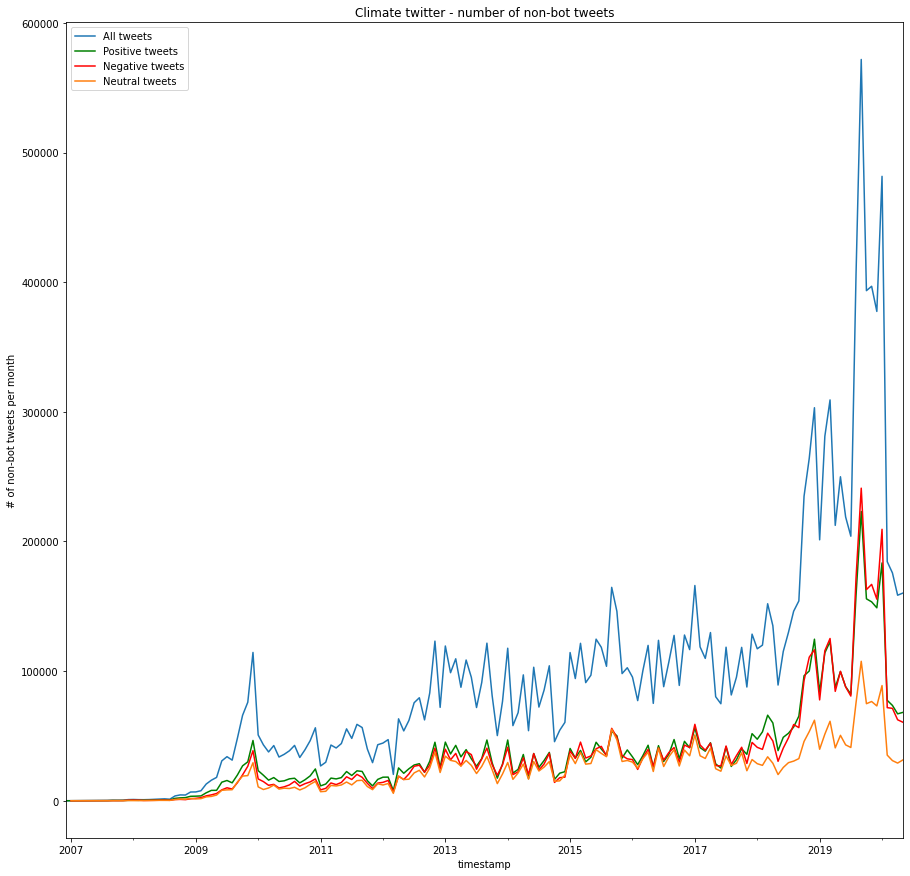

In [34]:
human_tweets.timestamp.resample("M").count().plot(figsize=(15,15), title="Climate twitter - number of non-bot tweets")
human_tweets.timestamp[human_tweets["compound"] > 0.05].resample("M").count().plot(color='g')
human_tweets.timestamp[human_tweets["compound"] < -0.05].resample("M").count().plot(color='r')
human_tweets.timestamp[human_tweets["compound"].between(-.05, .05)].resample("M").count().plot()
plt.legend(["All tweets", "Positive tweets", "Negative tweets", "Neutral tweets"])
plt.ylabel("# of non-bot tweets per month")
plt.show()

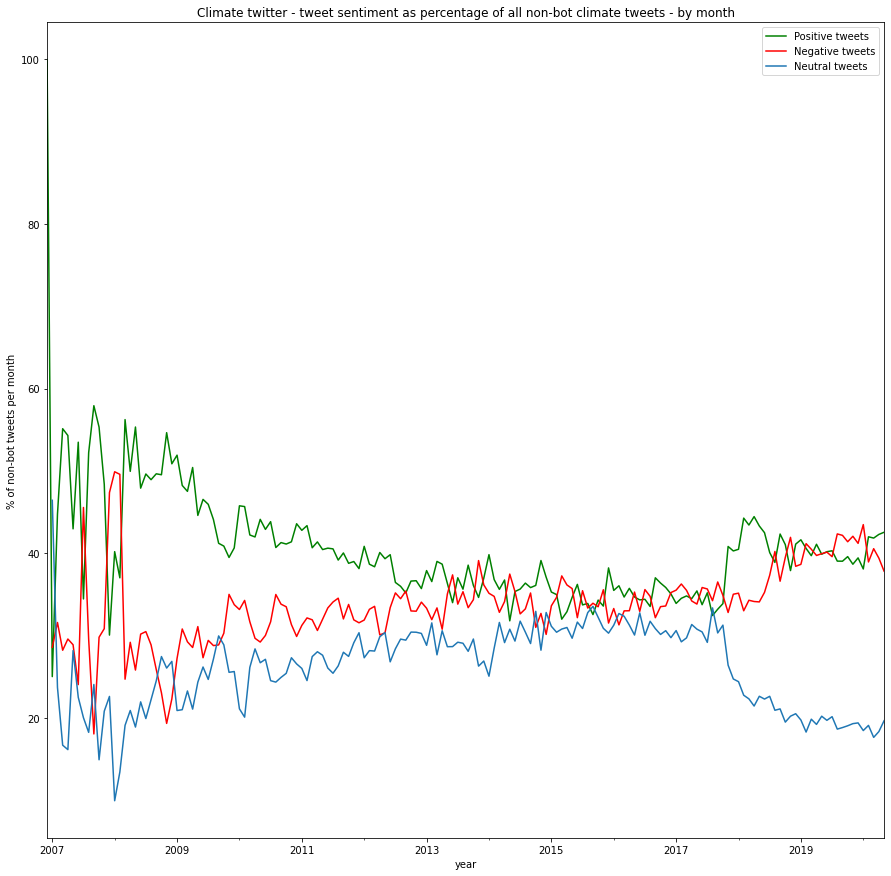

In [35]:
all_tweets_monthly = human_tweets.timestamp.resample("M").count()
pos_tweets = human_tweets.timestamp[human_tweets["compound"] > 0.05].resample("M").count()
pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
neg_tweets = human_tweets.timestamp[human_tweets["compound"] < -0.05].resample("M").count()
neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
neutral_tweets = human_tweets.timestamp[human_tweets["compound"].between(-.05, .05)].resample("M").count()
neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

pos_tweets_pc.plot(figsize=(15,15), title="Climate twitter - tweet sentiment as percentage of all non-bot climate tweets - by month",color="g")
neg_tweets_pc.plot(color='r')
neutral_tweets_pc.plot()
plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
plt.xlabel("year")
plt.ylabel("% of non-bot tweets per month")
plt.show()

In [36]:
%%time
deniers_merged = pd.merge(deniers, botscores, on="user_id")
deniers_merged

CPU times: user 5.53 s, sys: 63.8 ms, total: 5.59 s
Wall time: 5.58 s


,username


In [37]:
deniers_merged.index = deniers_merged.timestamp

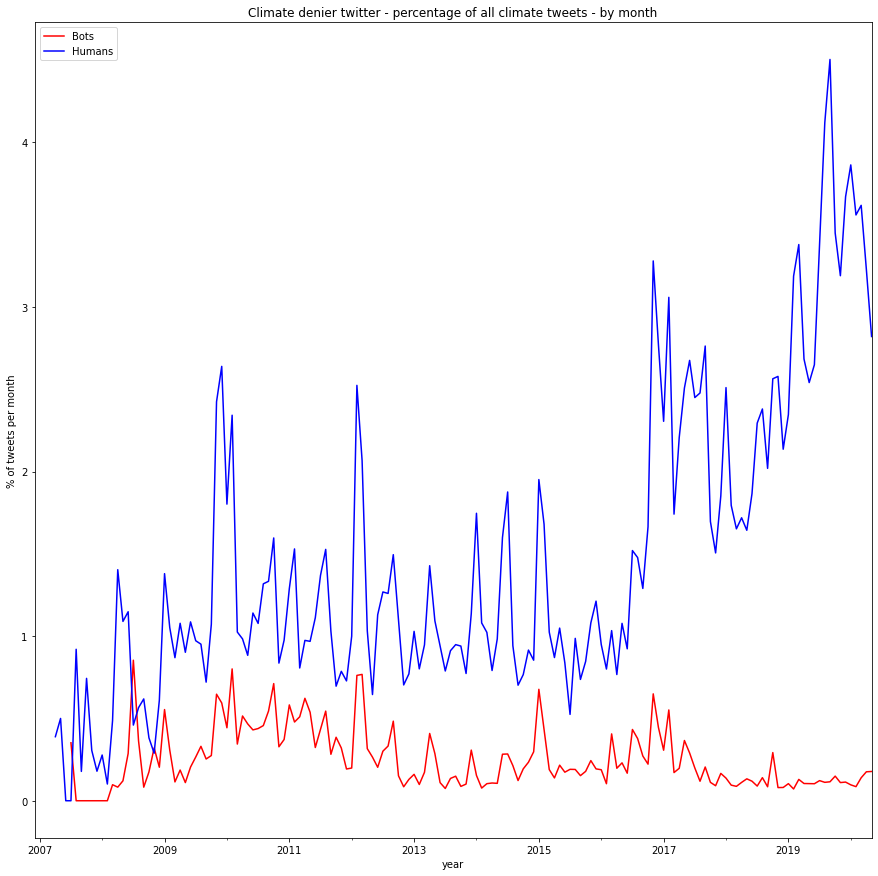

In [38]:
all_tweets_monthly = merged[~merged.prob_bot.isna()].timestamp.resample("M").count()
bot_denier_tweets = deniers_merged[deniers_merged.prob_bot > .5].timestamp.resample("M").count()
human_denier_tweets = deniers_merged[deniers_merged.prob_bot < .5].timestamp.resample("M").count()
bot_denier_tweet_pc = bot_denier_tweets / all_tweets_monthly * 100
human_denier_tweet_pc = human_denier_tweets / all_tweets_monthly * 100

bot_denier_tweet_pc.plot(figsize=(15,15), title="Climate denier twitter - percentage of all climate tweets - by month",color="r",label="Bots")
human_denier_tweet_pc.plot(color='b', label="Humans")
plt.legend(["Bots", "Humans"])
plt.ylabel("% of tweets per month")
plt.xlabel("year")
plt.show()

In [39]:
pattern = r"fake|not real|isn'?t real|doesn'?t exist|hoax|propaganda|conspiracy"
bot_deniers = deniers_merged[deniers_merged.prob_bot > .5]
display_filtered_df(bot_deniers, pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.


,text_with_emoji_formatted,compound
timestamp,,


In [45]:
top_bots = botscores[botscores.prob_bot > .5].sort_values(by="n_tweets", ascending=False).head(10)
top_bots

,user_id,screen_name,prob_bot,n_tweets


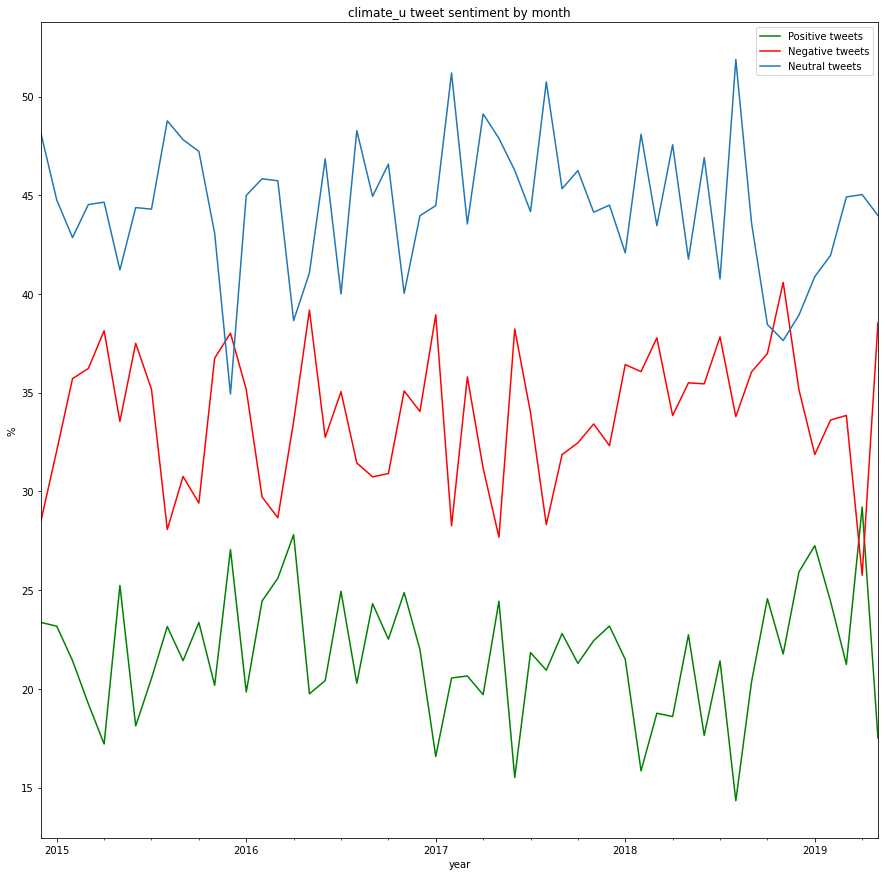

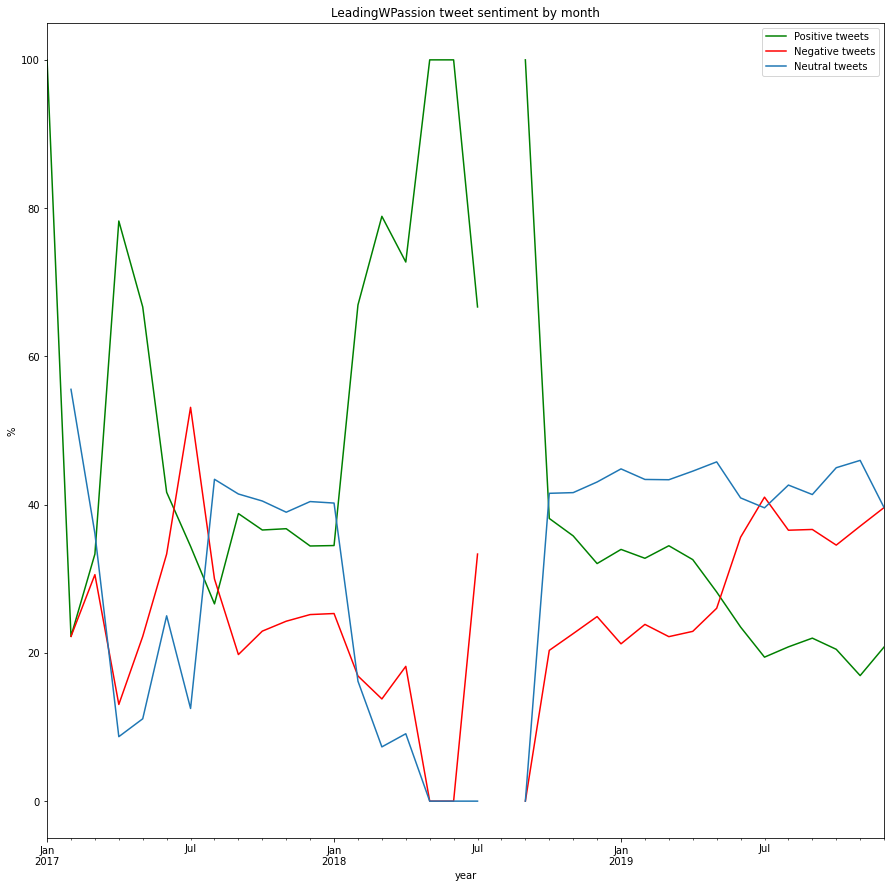

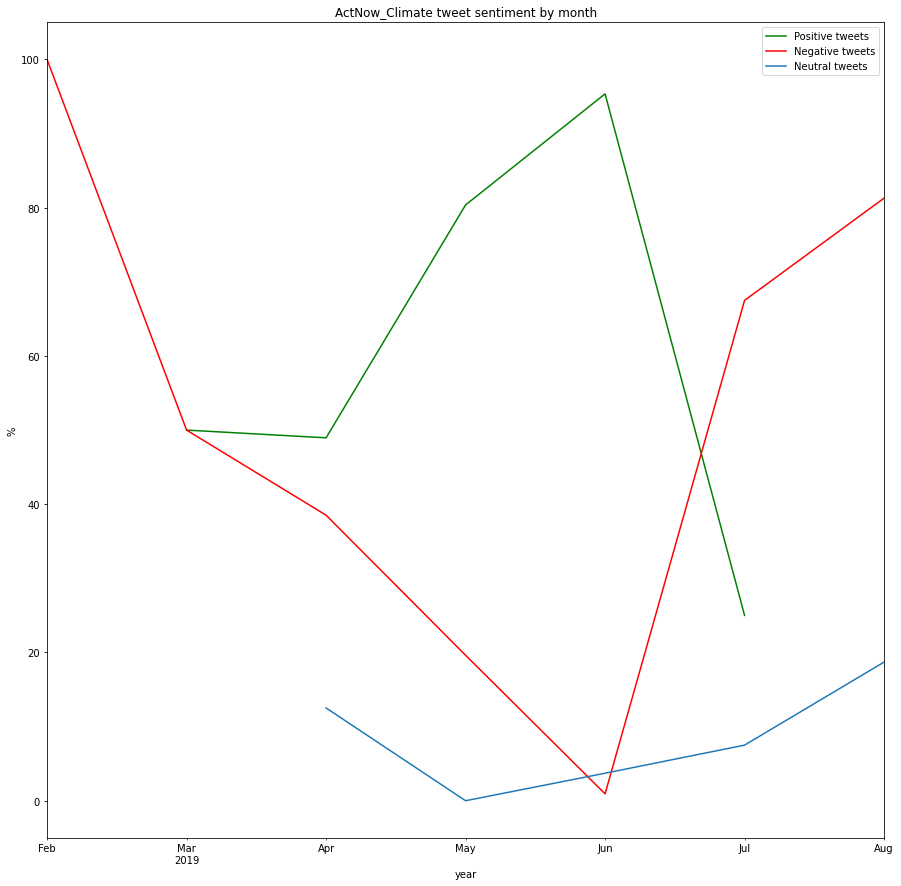

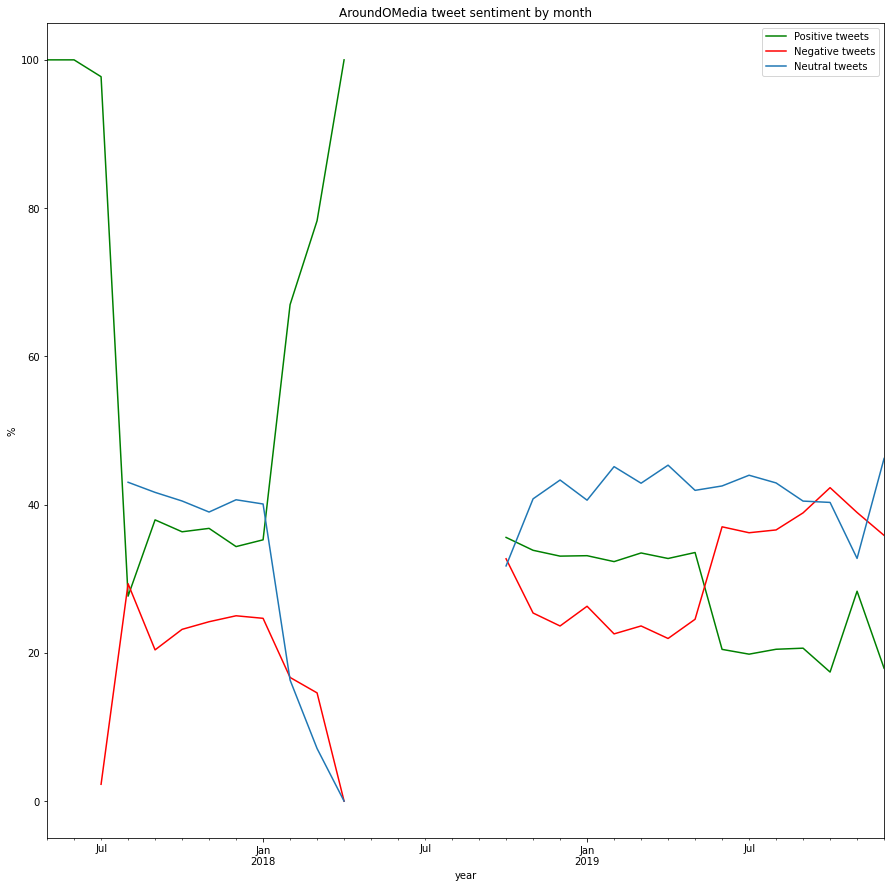

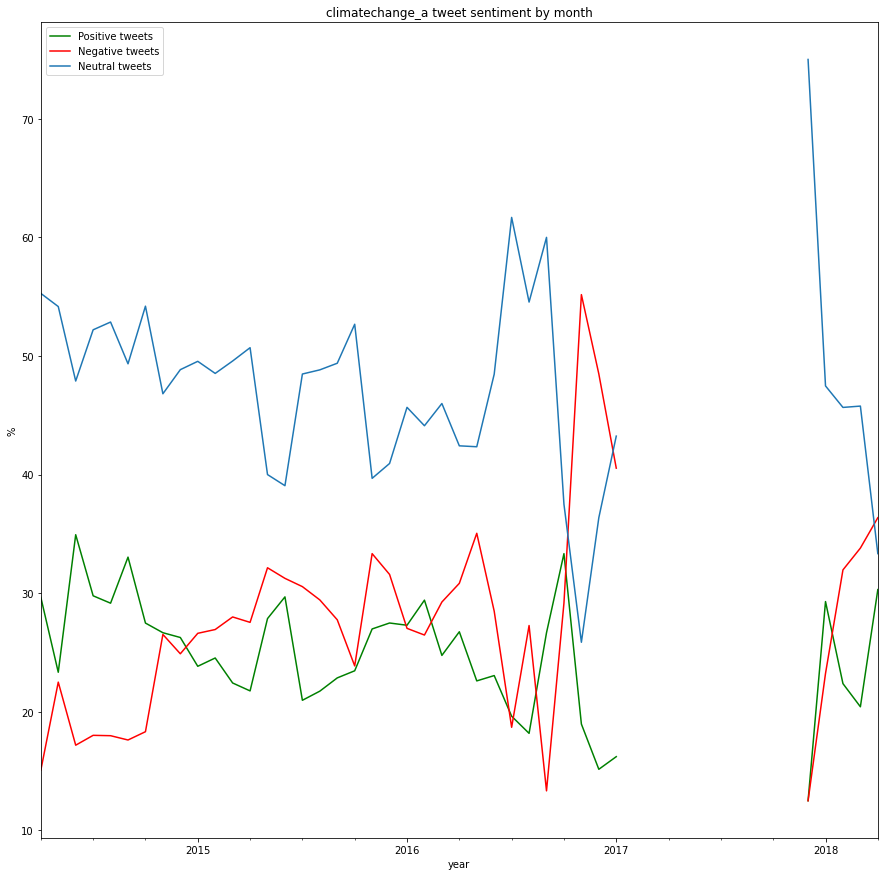

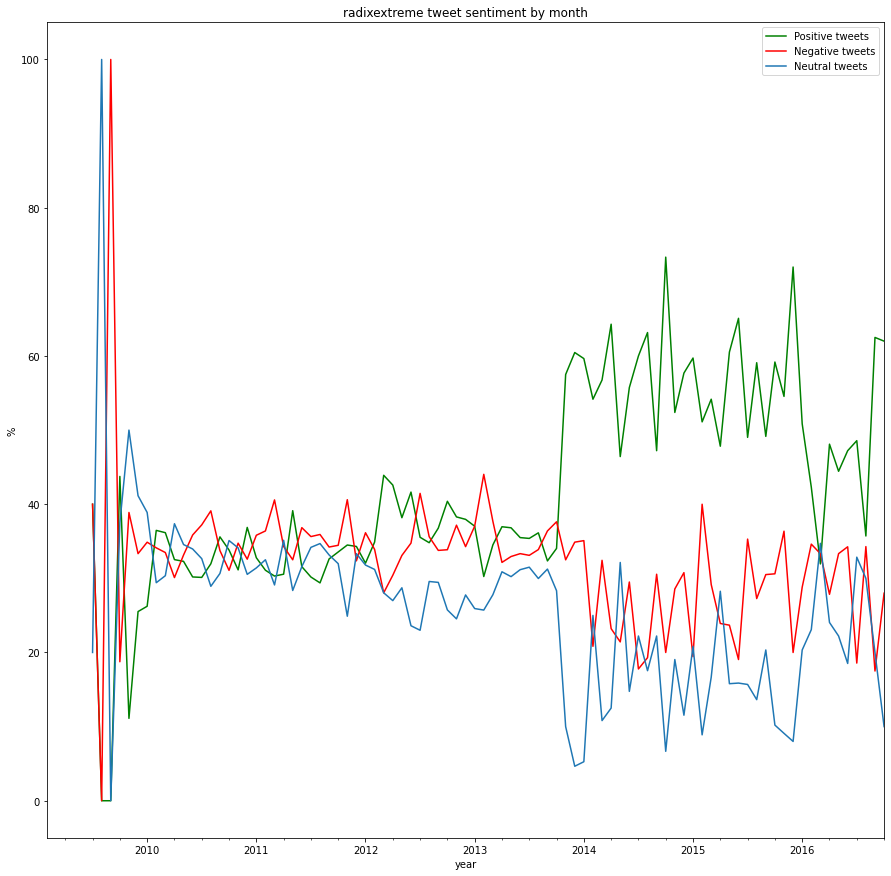

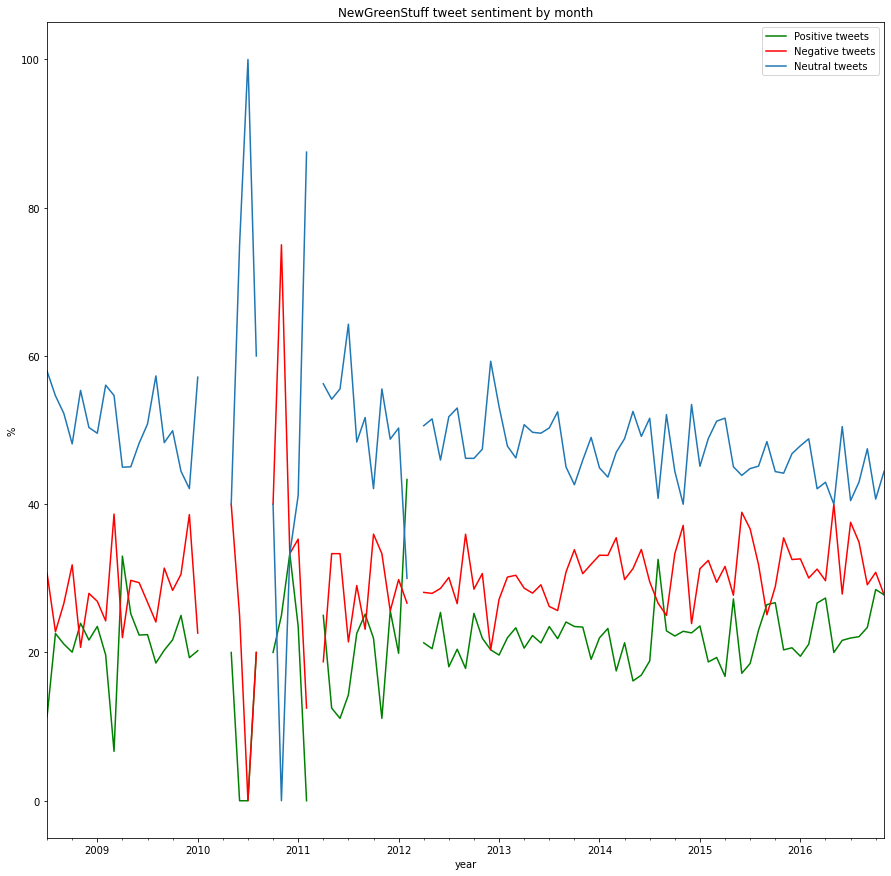

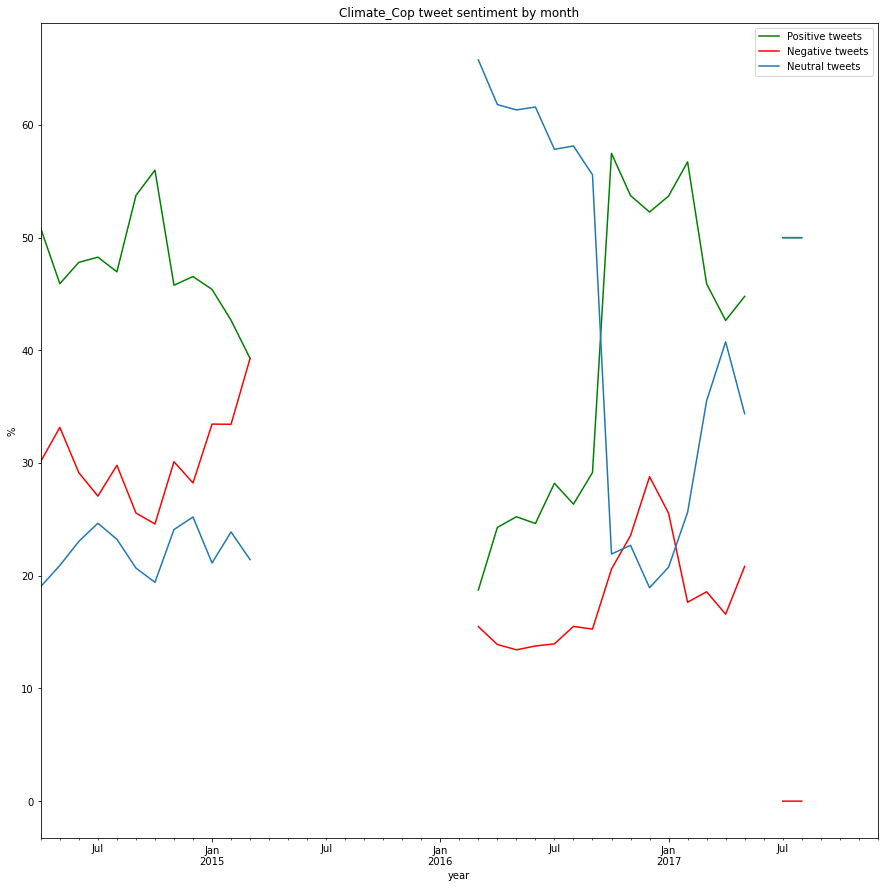

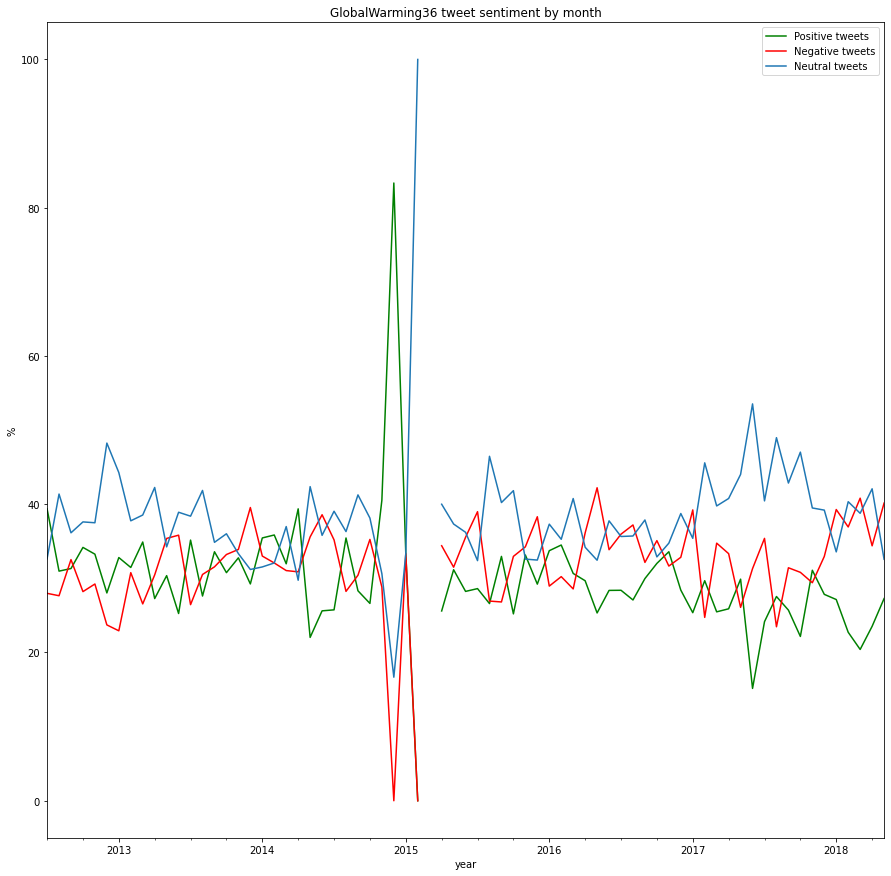

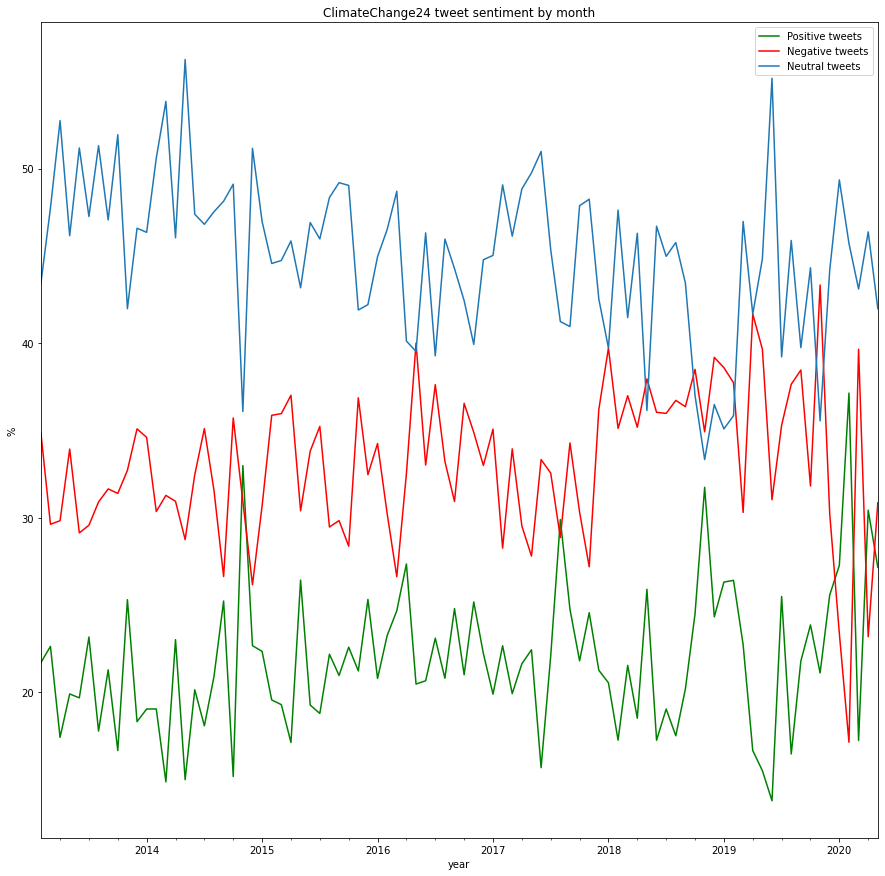

In [50]:
for i in range(10):
    bot_id = top_bots.user_id.iloc[i]
    name = top_bots.screen_name.iloc[i]
    filtered_df = bot_tweets[bot_tweets.user_id == bot_id]
    
    all_tweets_monthly = filtered_df.timestamp.resample("M").count()
    pos_tweets = filtered_df.timestamp[filtered_df["compound"] > 0.05].resample("M").count()
    pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
    neg_tweets = filtered_df.timestamp[filtered_df["compound"] < -0.05].resample("M").count()
    neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
    neutral_tweets = filtered_df.timestamp[filtered_df["compound"].between(-.05, .05)].resample("M").count()
    neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

    pos_tweets_pc.plot(figsize=(15,15), title=name + " tweet sentiment by month",color="g")
    neg_tweets_pc.plot(color='r')
    neutral_tweets_pc.plot()
    plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
    plt.xlabel("year")
    plt.ylabel("%")
    plt.show()